## 2. Empirical Line Correction
### By Susan Meerdink<sup>1</sup>

<sup>1</sup>The Machine Learning and Sensing Lab, Electrical and Computer Engineering, University of Florida, Gainesville, FL 32611
<url>https://faculty.eng.ufl.edu/machine-learning/</url>

**Background**  
* One of the first atmospheric correction methods was the empirical line approach (Conel et al., 1988). It is one of the easiest approaches to implement because it is based on linearly regressing between known targets and imagery. 
* More specifically, the empirical line approach for atmospheric correction requires field measurements of reflectance spectra for at least one bright target and one dark target. The imaging spectrometer data over the surface targets are linearly regressed against the field-measured reflectance spectra to derive the gain and offset curves. The gain and offset curves are then applied to the whole image for the derivation of surface reflectances for the entire scene. 


**Caveats**
* There has to be targets in the scene where you know the spectral reflectance at the time of sensor collection. This often means that a point spectrometer is needed in the field. 
* These targets have to be appropriate for correction - a range of albedos for targets from bright to dark.
* However, if changes occur in the atmospheric properties outside the area used for the empirical line approach, which is often the case, the spectral reflectance data will contain atmospheric features (Gao et al., 2009). 
* Furthermore, it is important (especially for large spatial areas) to have a few calibration targets AND validation targets to assess the error in the empirical relationships (Ariza et al., 2018). 
* Insufficient knowledge of the calibration procedure, the local conditions, and the spectral properties of the proposed calibration targets can lead to erroneous results (Hadley et al., 2005).

**So, when is it used?**
* Despite these limitations, this approach is still often used with drone-collected hyperspectral imagery because it is easy to implement, and estimation parameters for radiative transfer models (RTMs) are difficult.
* Here are a few references of papers using this approach for atmospheric correction:
    * Ariza, A., Robredo Irizar, M., & Bayer, S. (2018). Empirical line model for the atmospheric correction of sentinel-2A MSI images in the Caribbean Islands. European Journal of Remote Sensing, 51(1), 765–776. https://doi.org/10.1080/22797254.2018.1482732
    * Karpouzli, E., & Malthus, T. (2003). The empirical line method for the atmospheric correction of IKONOS imagery. International Journal of Remote Sensing, 24(5), 1143–1150. https://doi.org/10.1080/0143116021000026779

**Implementation**
* Various implementations of the ELM method have been used with varying degrees of success (Smith et al., 1999). The simplest approach is to use a single calibration target and assume that surfaces with zero reflectance will produce zero radiance at the sensor and that there is a linear relationship between radiance and reflectance.
* It is more common to use several calibration targets with a large spectral contrast between them, thus, removing the effect of atmospheric radiance. This method forces the remote sensing imaging spectrometer data to match with in situ reflectance spectra by a linear regression fit. 
* This empirical line method can be calculated as:  
$DN_b = \rho(\lambda)A_b + B_b$   
* where:
    * $DN_b$ is the digital output value for a givin pixel in band b
    * $\rho(\lambda)$ equals the reflectance of the target covers withing the instance field of view at a specific wavelength ($\lambda$)
    * $A_b$ is the multiplicative value affecting the DN
    * $B_b$ is the additive value
* The multiplicative term is concerned with transmittance and instrumental factors, and the additive value deals primarily with atmospheric path radiance and instrumental offset.

In [114]:
# Imports and setup
import numpy as np
import os.path
import scipy.io
import rasterio
from spectral import *

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
default_dpi = mpl.rcParamsDefault['figure.dpi']

In [161]:
# Load the image
# Note: Image will have georeferencing error because it does gone through georeferencing yet which is normally done after reflectance.
imgFile = rasterio.open('img_radiance', 'r')

# Loading Metadata Data
data_anc = np.load('img_metadata.npz')
print('Ancillary data associated with this file: ' + str(data_anc.files))

# Set some of the variables from the ancillary data
wave = data_anc['wavelengths']
rgb_index = data_anc['rgb_index']
rgb_image = data_anc['rgb_image']

# Grab Some information about this image
pixHeight = rgb_image.shape[0]
pixWidth = rgb_image.shape[1]
numBands = len(wave)
print('There are ' + str(numBands) + ' bands for this ' + str(pixHeight) + ' by ' + str(pixWidth) + ' pixel image.')

Ancillary data associated with this file: ['wavelengths', 'rgb_index', 'rgb_image']
There are 273 bands for this 401 by 640 pixel image.


To apply this method, two or more homogeneous (both spatially and spectrally) areas with different albedos (from the brightest to the darkest target) are needed. 

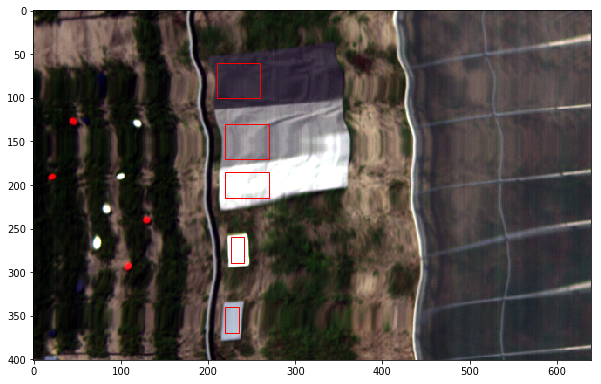

In [69]:
# Plot RGB Image to grab calibration pixels
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.imshow(rgb_image)

# Plotting rectangles around calibration targets
left=[210,220,220,226,220]
bottom=[60,130,185,260,340]
width=[50,50,50,15,15]
height=[40,40,30,30,30]
for i in range(0,len(left)):
    p = plt.Rectangle((left[i], bottom[i]), width[i], height[i], fill=False, color='red')
    p.set_clip_on(False)
    ax.add_patch(p)

Now that we have determine which pixels contain calibration target, we will extract the pixels from those targets in our scene.

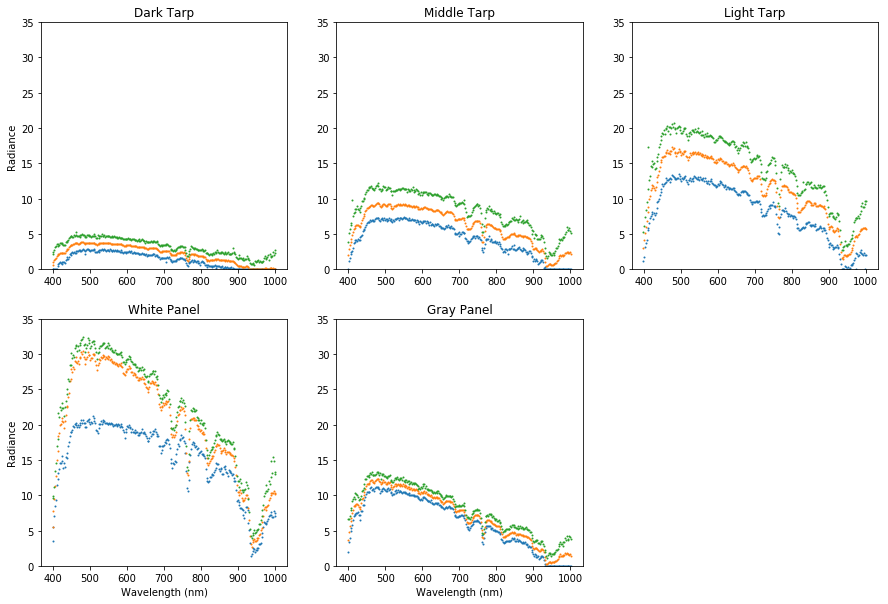

In [70]:
# Extracting pixels from scene for the 5 calibration targets
# We are going to extract the pixels for each target and calculate the min/mean/max
insceneTargets = np.zeros((3,5,numBands))
for i in range(0,len(left)): #
    window = ((bottom[i], bottom[i] + height[i]),(left[i], left[i] + width[i]))
    data = imgFile.read(window=window)  # Extract spectra from image
    dataFlat = np.reshape(data,(numBands,-1))
    insceneTargets[0,i,:] = np.amin(dataFlat,1) 
    insceneTargets[1,i,:] = np.mean(dataFlat,1) 
    insceneTargets[2,i,:] = np.amax(dataFlat,1) 

# Plotting Targets
labels = ['Dark Tarp','Middle Tarp','Light Tarp','White Panel','Gray Panel']
plt.figure(figsize=(15,10))
for i in range(0,len(left)): # 
    plt.subplot(2,3,i+1)
    plt.scatter(wave,insceneTargets[0,i,:],s=1)
    plt.scatter(wave,insceneTargets[1,i,:],s=1)
    plt.scatter(wave,insceneTargets[2,i,:],s=1)
    plt.ylim(0,35)
    plt.title(labels[i])
    if i == 0 or i == 3:
        plt.ylabel('Radiance')
    if i == 3 or i == 4:
        plt.xlabel('Wavelength (nm)')

Now that we have our spectra from the scene, we will load the laboratory measured target spectra. Ideally, you would use a point spectrometer in the field when collecting the imagery to capture those exact environmental conditions. We do not have that data available, so we are going to use spectra collected with a point spectrometer in indoor conditions. 


This dataset has 5 with 2151 bands.
['Dark Tarp' 'Middle Tarp' 'Light Tarp' 'Painted White' 'Painted Gray']


(350, 1000)

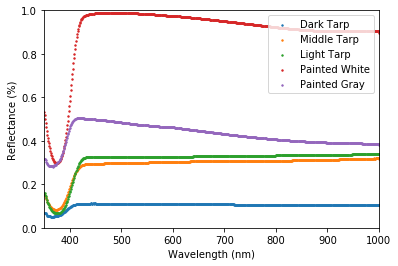

In [195]:
# Load original spectrometer data
indoorTargetsOriginal = np.loadtxt('target_spectra_reference.csv', delimiter=',',dtype='str')

# Grab wavelength and data from file
waveASD = indoorTargetsOriginal[0,1:indoorTargetsOriginal.shape[1]].astype('int')
indoorTargets2151 = indoorTargetsOriginal[1:indoorTargetsOriginal.shape[0],1:indoorTargetsOriginal.shape[1]].astype('float')

# Grab targets names
indoorTargetsName = indoorTargetsOriginal[1:indoorTargetsOriginal.shape[0],0]

# Reorganizing to match image target order
indoorTargets2151 = indoorTargets2151[[2,4,3,0,1],:]
indoorTargetsName = indoorTargetsName[[2,4,3,0,1]]

print('This dataset has ' + str(indoorTargets2151.shape[0]) + ' with ' + str(indoorTargets2151.shape[1]) + ' bands.')
print(indoorTargetsName)

# Plot Data
plt.figure()
for w in range(0,indoorTargets2151.shape[0]):
    plt.scatter(waveASD, indoorTargets2151[w,:],s=2)
plt.legend(indoorTargetsName,loc='upper right')
plt.ylim(0,1)
plt.ylabel('Reflectance (%)')
plt.xlabel('Wavelength (nm)')
plt.xlim(350, 1000)

The point spectrometer collects 2151 bands from 350 to 2500 nm. This does not match the spectral resolution of the Headwall Nano Hyperspec camera used to collect the imagery. We need to resampled the spectrometer data to match the image's spectral resolution. Ideally you would do this using the spectral response function for the camera, but I was not able to find this information publically available. Instead, we will use the wavelength centers and full width half max (FWHM) of 6 nm to resample the data. However, no sensor noise was added in. 

Text(0.5, 0, 'Wavelength (nm)')

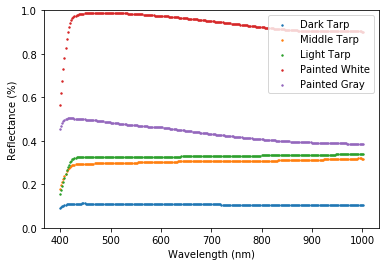

In [196]:
# Resample the data to Nano Hyperspec 
fwhmASD = np.tile(1.4, (len(waveASD))) # FWHM of Point Spectrometer
fwhmNano = np.tile(6, numBands)  # FWHM of Nano Hyperspec Camera
resample = BandResampler(waveASD, wave, fwhmASD, fwhmNano)
indoorTargets = np.zeros((5,numBands))
for i in range(0, indoorTargets2151.shape[0]):
    indoorTargets[i,:] = resample(indoorTargets2151[i,:])

# Plot Data
plt.figure()
for w in range(0,indoorTargets.shape[0]):
    plt.scatter(wave, indoorTargets[w,:],s=2)
plt.legend(indoorTargetsName,loc='upper right')
plt.ylim(0,1)
plt.ylabel('Reflectance (%)')
plt.xlabel('Wavelength (nm)')

The gain and offset values are derived using an ordinary least squares regression fitting method Smith & Milton, 1999. The image DN and reflectance data are equated on a band-by-band basis (i.e., not pixel-by pixel) using a linear regression, thus removing the solar irradiance and the atmospheric path radiance (Hadley et al., 2005).

C:\Users\susanmeerdink\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


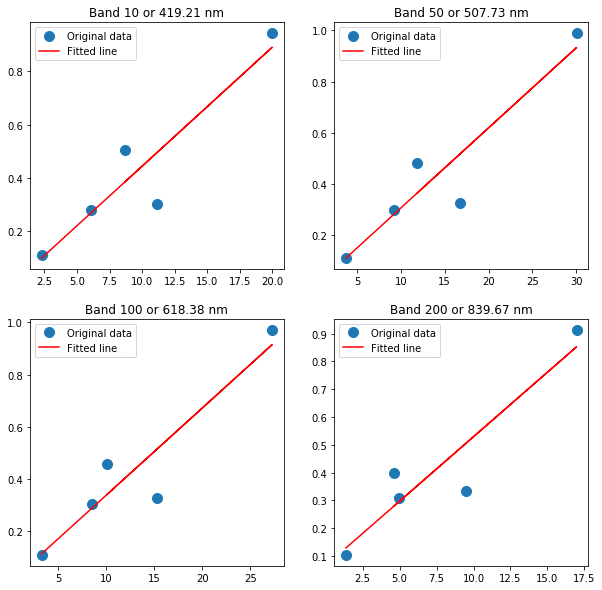

In [203]:
# Calculate the per band Ordinary least squares values
m = np.zeros((numBands)) # Slope
c = np.zeros((numBands)) # intercept
for i in range(0, numBands):
    A = np.transpose(np.vstack([insceneTargets[1,:,i], np.ones(insceneTargets.shape[1])]))
    mymodel = np.linalg.lstsq(A, indoorTargets[:,i])
    m[i] = mymodel[0][0]
    c[i] = mymodel[0][1]

# Plot a few of the regressions
plt.figure(figsize=(10,10))
plt.subplot(2,2,1) 
b = 9 # Band 10
plt.plot(insceneTargets[1,:,b], indoorTargets[:,b], 'o', label='Original data', markersize=10)
plt.plot(insceneTargets[1,:,b], m[b]*insceneTargets[1,:,b] + c[b], 'r', label='Fitted line')
plt.title('Band ' + str(b+1) + ' or ' + str(round(wave[b],2)) + ' nm')
plt.legend()

plt.subplot(2,2,2) 
b = 49 # Band 50
plt.plot(insceneTargets[1,:,b], indoorTargets[:,b], 'o', label='Original data', markersize=10)
plt.plot(insceneTargets[1,:,b], m[b]*insceneTargets[1,:,b] + c[b], 'r', label='Fitted line')
plt.title('Band ' + str(b+1) + ' or ' + str(round(wave[b],2)) + ' nm')
plt.legend()

plt.subplot(2,2,3) 
b = 99 # Band 100
plt.plot(insceneTargets[1,:,b], indoorTargets[:,b], 'o', label='Original data', markersize=10)
plt.plot(insceneTargets[1,:,b], m[b]*insceneTargets[1,:,b] + c[b], 'r', label='Fitted line')
plt.title('Band ' + str(b+1) + ' or ' + str(round(wave[b],2)) + ' nm')
plt.legend()

plt.subplot(2,2,4) 
b = 199 # Band 200
plt.plot(insceneTargets[1,:,b], indoorTargets[:,b], 'o', label='Original data', markersize=10)
plt.plot(insceneTargets[1,:,b], m[b]*insceneTargets[1,:,b] + c[b], 'r', label='Fitted line')
plt.title('Band ' + str(b+1) + ' or ' + str(round(wave[b],2)) + ' nm')
plt.legend()

Now we will apply the per band coefficients to the imagery to convert from Radiance to Reflectance.

In [198]:
# Converting imagery to reflectance using empirical line method
imgRef = np.zeros((pixHeight, pixWidth, numBands))
for b in range(0,numBands): 
    imgRad = imgFile.read(indexes=b+1) # rasterio does count base 1 for bands
    imgRef[:,:,b] = imgRad*m[b] + c[b]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'Wavelength(nm)')

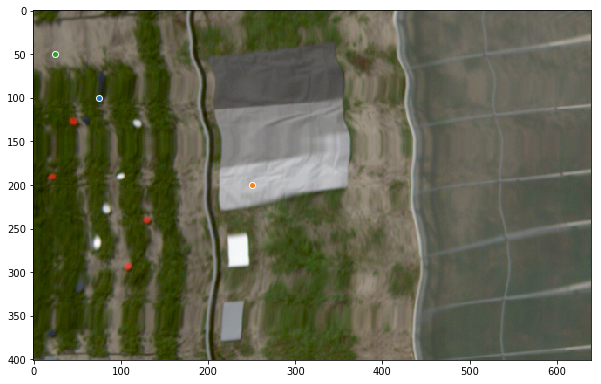

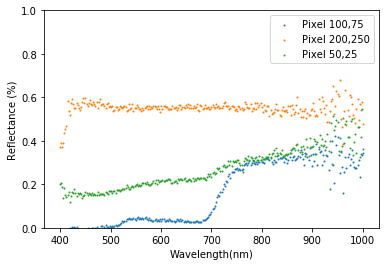

In [201]:
# Plot RGB of Reflectance Image and pull out some pixels
x = [100,200,50]
y = [75,250,25]
plt.figure(figsize=(10,10)) 
plt.imshow(imgRef[:,:, rgb_index]**(1/2)) # Applying Gamma Correction to brighten image
for i in range(0,len(x)):
    plt.scatter(y[i],x[i], edgecolors='w')
plt.show

# Loop through spectra to plot
plt.figure()
text = []
for i in range(0,len(x)):
    text.append('Pixel ' + str(x[i]) + ',' + str(y[i]))
    plt.scatter(wave,imgRef[x[i],y[i]], s=1)
plt.legend(text)
plt.ylim(0,1)
plt.ylabel('Reflectance (%)')
plt.xlabel('Wavelength(nm)')

Now let's compare the reflectance of the targets from the scene to the laboratory measurements.

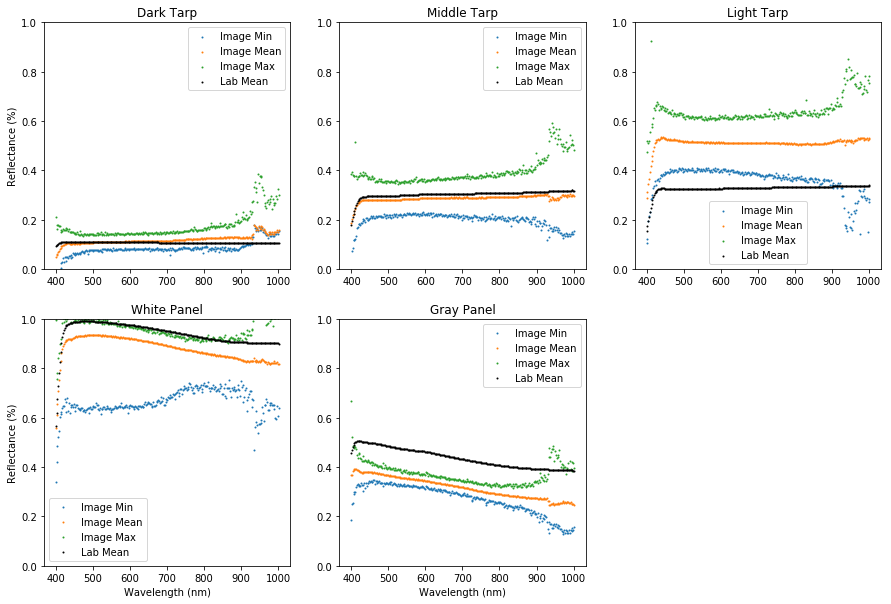

In [213]:
# Extracting pixels from scene for the 5 calibration targets
# We are going to extract the pixels for each target and calculate the min/mean/max
insceneTargets = np.zeros((3, 5,numBands))
for i in range(0,len(left)): #
    meshX, meshY = np.meshgrid(np.arange(bottom[i],bottom[i] + height[i]), np.arange(left[i],left[i] + width[i]))
    data = imgRef[meshX,meshY,:]
    dataFlat = np.transpose(np.reshape(data,(-1,len(wave))))
    insceneTargets[0,i,:] = np.amin(dataFlat,1) 
    insceneTargets[1,i,:] = np.mean(dataFlat,1) 
    insceneTargets[2,i,:] = np.amax(dataFlat,1) 

# Plotting Targets from Image with Lab Collected Targets
labels = ['Dark Tarp','Middle Tarp','Light Tarp','White Panel','Gray Panel']
plt.figure(figsize=(15,10))
for i in range(0,len(left)): # 
    plt.subplot(2,3,i+1)
    plt.scatter(wave,insceneTargets[0,i,:],s=1,label='Image Min')
    plt.scatter(wave,insceneTargets[1,i,:],s=1,label='Image Mean')
    plt.scatter(wave,insceneTargets[2,i,:],s=1,label='Image Max')
    plt.scatter(wave,indoorTargets[i,:],color='k',s=1,label='Lab Mean')
    plt.ylim(0,1)
    plt.title(labels[i])
    plt.legend()
    if i == 0 or i == 3:
        plt.ylabel('Reflectance (%)')
    if i == 3 or i == 4:
        plt.xlabel('Wavelength (nm)')

**References**
* Ariza, A., Robredo Irizar, M., & Bayer, S. (2018). Empirical line model for the atmospheric correction of sentinel-2A MSI images in the Caribbean Islands. European Journal of Remote Sensing, 51(1), 765–776. https://doi.org/10.1080/22797254.2018.1482732
* Karpouzli, E., & Malthus, T. (2003). The empirical line method for the atmospheric correction of IKONOS imagery. International Journal of Remote Sensing, 24(5), 1143–1150. https://doi.org/10.1080/0143116021000026779